# Unified Data Analysis

## Install Dependencies and Import Requirements

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/SMART-CITIES/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/SMART-CITIES


In [ ]:
!pip install haversine

In [ ]:
!pip install pysal

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
import branca.colormap as cm
from folium.plugins import AntPath
from pysal.lib import weights
from pysal.explore import esda
from haversine import haversine, Unit
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


## Merge and pre-process data

In [ ]:
# File paths
file1 = './raw/DB1.csv'
file2 = './raw/DB2.csv'
file3 = './raw/DB3.csv'
file4 = './raw/DB4.csv'

# Read the CSV files into DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)

# Define the new header
new_header = ['Timestamp', 'Temperature', 'Humidity', 'Air Quality', 'Latitude', 'Longitude']

# Set the header
df1.columns = new_header
df2.columns = new_header
df3.columns = new_header
df4.columns = new_header

# Adjust timestamp type
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'], format='%d/%m/%Y%H:%M:%S')
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], format='%d/%m/%Y %H:%M:%S')
df3['Timestamp'] = pd.to_datetime(df3['Timestamp'], format='%d/%m/%Y %H:%M:%S')
df4['Timestamp'] = pd.to_datetime(df4['Timestamp'], format='%d/%m/%Y %H:%M:%S')

# Define the cutoff timestamp
begin_timestamp = pd.Timestamp('2024-06-20 15:24:00')
end_timestamp = pd.Timestamp('2024-06-20 15:55:00')

# Filter the DataFrame

filtered_df1 = df1[df1['Timestamp'] >= begin_timestamp]

filtered_df1 = filtered_df1[filtered_df1['Timestamp'] <= end_timestamp]

filtered_df2 = df2[df2['Timestamp'] >= begin_timestamp]

filtered_df2 = filtered_df2[filtered_df2['Timestamp'] <= end_timestamp]

filtered_df3 = df3[df3['Timestamp'] >= begin_timestamp]

filtered_df3 = filtered_df3[filtered_df3['Timestamp'] <= end_timestamp]

filtered_df4 = df4[df4['Timestamp'] >= begin_timestamp]

filtered_df4 = filtered_df4[filtered_df4['Timestamp'] <= end_timestamp]

# Concatenate DataFrames vertically
df_combined = pd.concat([filtered_df1, filtered_df2, filtered_df3, filtered_df4], ignore_index=True)

# Save the concatenated dataframe to a new CSV file
output_file = './filtered/unified-db.csv'

# Save the combined DataFrame to a new CSV file
df_combined.to_csv(output_file, index=False)


In [ ]:
# Load the CSV file to inspect its contents
data = pd.read_csv(output_file)

# Display the first few rows of the dataframe to understand its structure
data.head()

,Timestamp,Temperature,Humidity,Air Quality,Latitude,Longitude
0,2024-06-20 15:24:02,28.69,50.97,28,45.473469,9.202674
1,2024-06-20 15:24:07,28.73,50.74,27,45.473470,9.202674
2,2024-06-20 15:24:12,28.78,49.94,27,45.473470,9.202674
3,2024-06-20 15:24:17,28.80,49.66,29,45.473470,9.202674
4,2024-06-20 15:24:22,28.77,49.70,27,45.473470,9.202673


In [ ]:
# Describe the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,1302.0,28.931974,0.716834,27.370000,28.420000,28.900000,29.370000,31.170000
Humidity,1302.0,48.555760,2.679079,43.030000,46.500000,48.240000,49.980000,59.470000
Air Quality,1302.0,39.691244,11.498216,24.000000,28.000000,37.000000,46.000000,74.000000
Latitude,1302.0,45.474262,0.001066,45.471935,45.473489,45.474102,45.474859,45.477260
Longitude,1302.0,9.200012,0.002210,9.195724,9.198159,9.199922,9.201978,9.204596


In [ ]:
# Drop NaN rows
data = data.dropna()

In [ ]:
# Filter out outliers
data = data[np.abs(data['Temperature']-data['Temperature'].mean()) <= (3*data['Temperature'].std())]

In [ ]:
# Describe the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,1301.0,28.930254,0.714416,27.370000,28.420000,28.900000,29.370000,30.940000
Humidity,1301.0,48.558640,2.678094,43.030000,46.500000,48.250000,49.980000,59.470000
Air Quality,1301.0,39.676403,11.490155,24.000000,28.000000,37.000000,46.000000,74.000000
Latitude,1301.0,45.474263,0.001065,45.471935,45.473489,45.474105,45.474860,45.477260
Longitude,1301.0,9.200010,0.002211,9.195724,9.198159,9.199916,9.201978,9.204596


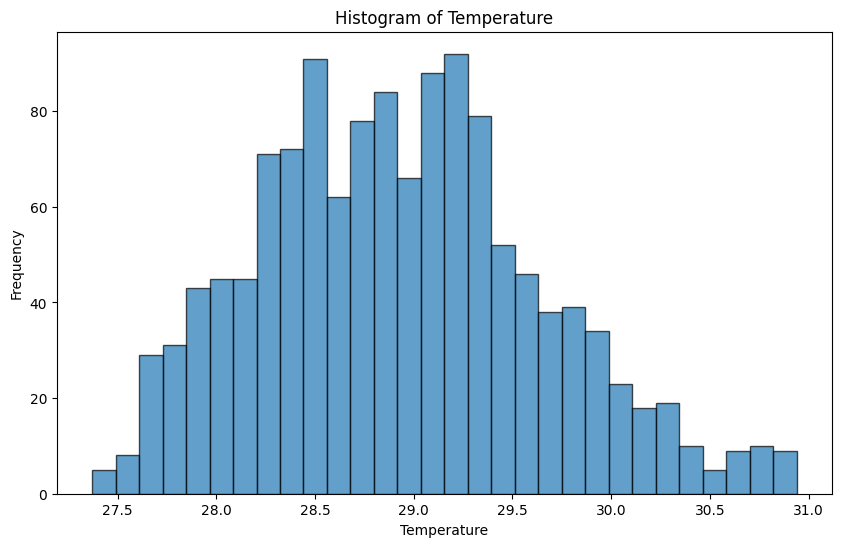

In [ ]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(data['Temperature'], bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Histogram of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

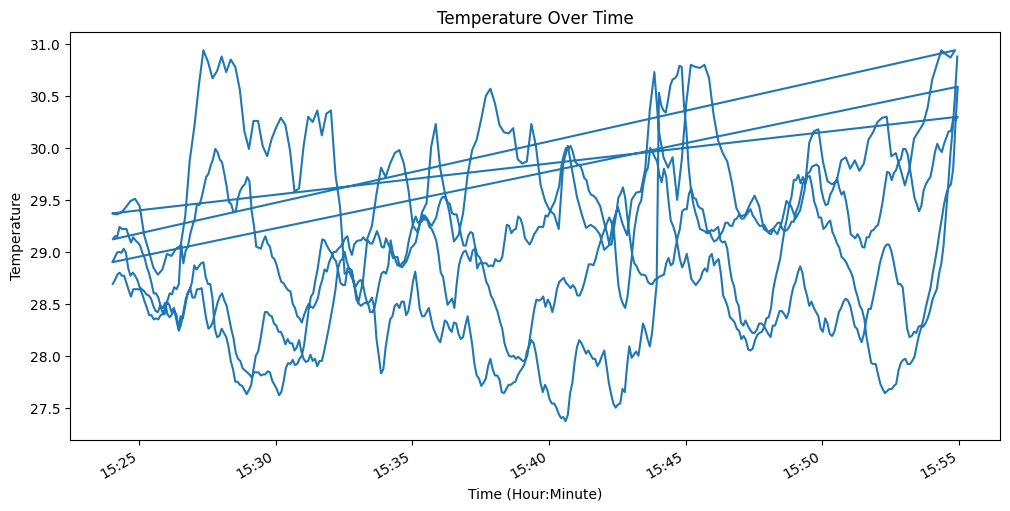

In [ ]:
# Ensure the Timestamp column is in datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

plt.figure(figsize=(12, 6))

# Plotting the data using the 'Timestamp' column for the x-axis
plt.plot(data['Timestamp'], data['Temperature'])

# Formatting the x-axis to show hour and minute
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting the labels and title
plt.xlabel('Time (Hour:Minute)')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')

# Rotating the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Display the plot
plt.show()


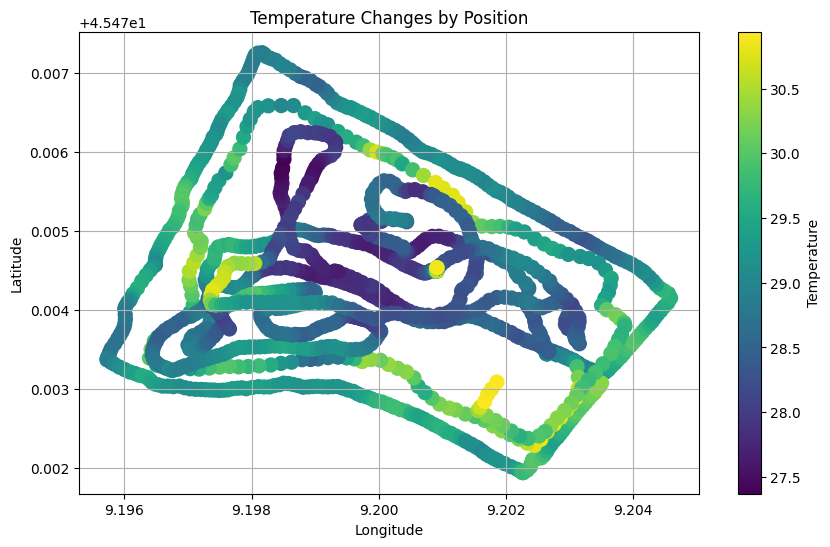

In [ ]:
df = data.copy()
# Plot temperature vs coordinates
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['Longitude'], df['Latitude'], c=df['Temperature'], cmap='viridis', s=100)
plt.colorbar(sc, label='Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Temperature Changes by Position')
plt.grid(True)
plt.show()

## Analysis of distances

<ipython-input-14-5b21d9629c53>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(df_no_perimeter['Longitude'], df_no_perimeter['Latitude'], cmap='viridis', s=100)


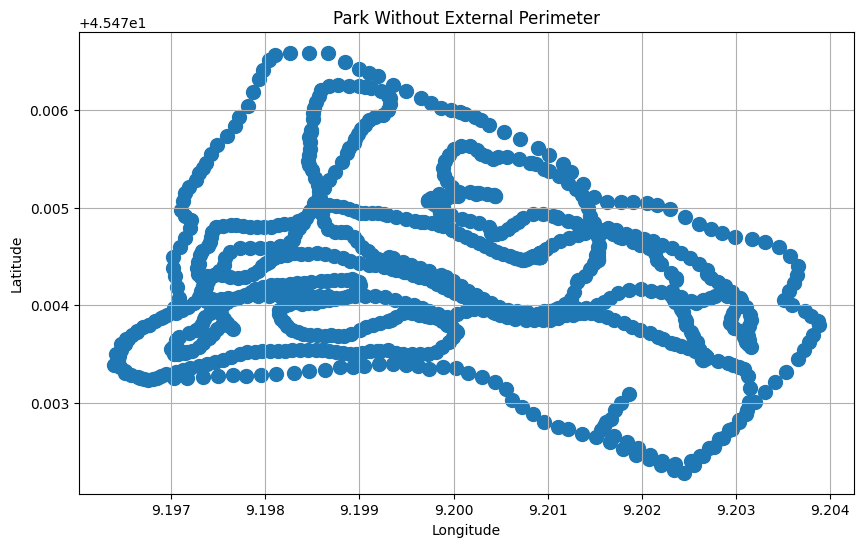

In [ ]:
# Concatenate DataFrames vertically
df_no_perimeter = pd.concat([filtered_df2, filtered_df3, filtered_df4], ignore_index=True)

plt.figure(figsize=(10, 6))
sc = plt.scatter(df_no_perimeter['Longitude'], df_no_perimeter['Latitude'], cmap='viridis', s=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Park Without External Perimeter')
plt.grid(True)
plt.show()

<ipython-input-15-75f0759e7418>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(perimeter['Longitude'], perimeter['Latitude'], cmap='viridis', s=100)


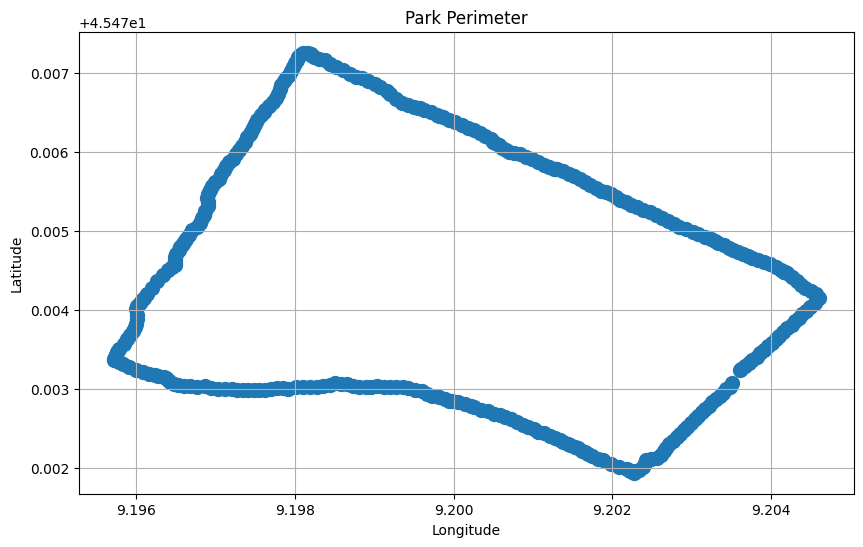

In [ ]:

# Plot temperature vs coordinates

# Define the cutoff timestamp
begin_timestamp = pd.Timestamp('2024-06-20 15:27:00')
end_timestamp = pd.Timestamp('2024-06-20 15:55:00')

# Filter the DataFrame

perimeter = df1[df1['Timestamp'] >= begin_timestamp]

perimeter = perimeter[perimeter['Timestamp'] <= end_timestamp]


plt.figure(figsize=(10, 6))
sc = plt.scatter(perimeter['Longitude'], perimeter['Latitude'], cmap='viridis', s=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Park Perimeter')
plt.grid(True)
plt.show()

In [ ]:

# Calculate the average latitude and longitude
average_lat = np.mean(perimeter['Latitude'])
average_lon = np.mean(perimeter['Longitude'])

print(f"Barycenter coordinates: ({average_lat}, {average_lon})")

Barycenter coordinates: (45.4743487718254, 9.19991987797619)


<ipython-input-17-6cc1da20498e>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(perimeter['Longitude'], perimeter['Latitude'], cmap='viridis', s=100)


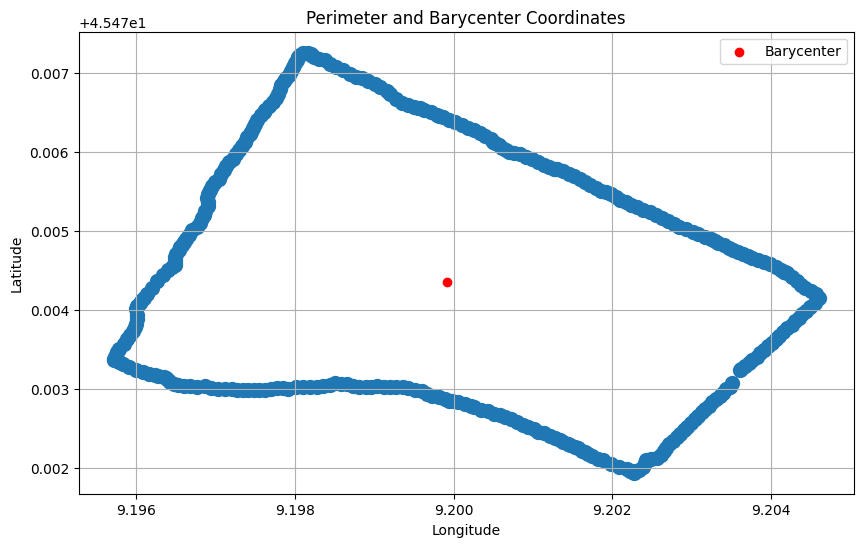

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(perimeter['Longitude'], perimeter['Latitude'], cmap='viridis', s=100)
plt.scatter(average_lon, average_lat, color='red', marker='o', label='Barycenter')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Perimeter and Barycenter Coordinates')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Function to calculate distance using Haversine formula
def calculate_distance(row):
    coords_1 = (row['Latitude'], row['Longitude'])
    coords_2 = (average_lat, average_lon)
    return haversine(coords_1, coords_2, unit=Unit.METERS)

# Apply the function to each row and store results in a new column
df['Distance_from_Barycenter'] = df.apply(calculate_distance, axis=1)

Haversine distance:

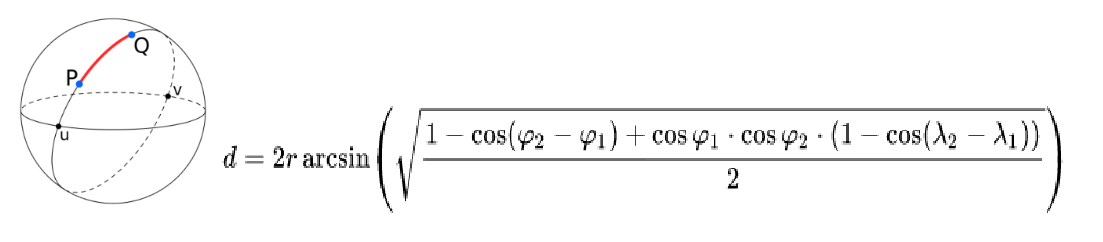

<ipython-input-19-51940ac4469d>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['Longitude'], df['Latitude'], cmap='viridis', s=100)


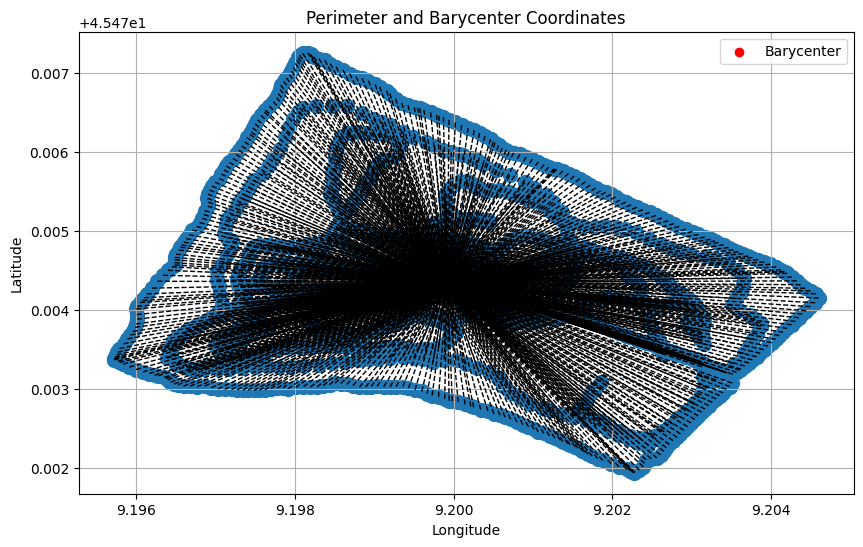

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['Longitude'], df['Latitude'], cmap='viridis', s=100)
plt.scatter(average_lon, average_lat, color='red', marker='o', label='Barycenter')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Perimeter and Barycenter Coordinates')
plt.legend()
plt.grid(True)

# Plot lines showing the distances to the barycenter
for i, row in df.iterrows():
    plt.plot([row['Longitude'], average_lon], [row['Latitude'], average_lat], 'k--', linewidth=1)

<ipython-input-20-3d41aeb4257a>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X, Y, cmap='viridis', s=100, label='Data Points')


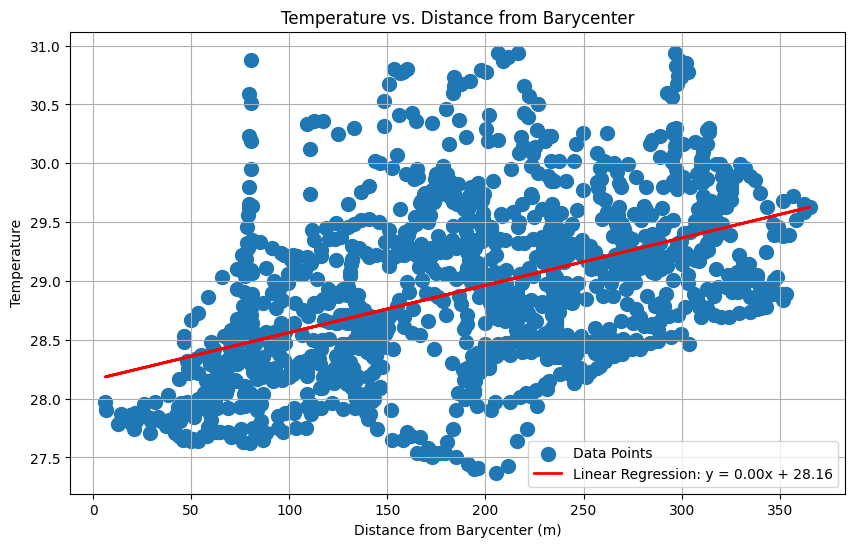

In [ ]:
# Extract X (distance) and Y (temperature) for linear regression
X = df[['Distance_from_Barycenter']].values
Y = df['Temperature'].values

# Perform linear regression
model = LinearRegression()
model.fit(X, Y)
intercept = model.intercept_
slope = model.coef_[0]

# Predict Y values using the model
predicted_Y = model.predict(X)

# Plotting temperature against distance from barycenter with linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, cmap='viridis', s=100, label='Data Points')
plt.plot(X, predicted_Y, color='red', linewidth=2, label=f'Linear Regression: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('Distance from Barycenter (m)')
plt.ylabel('Temperature')
plt.title('Temperature vs. Distance from Barycenter')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Function to calculate distance to closest point on perimeter and get closest perimeter point
def calculate_distance_to_perimeter(row):
    min_distance = float('inf')
    closest_point = None
    for index, perimeter_point in perimeter.iterrows():
        coords_1 = (row['Latitude'], row['Longitude'])
        coords_2 = (perimeter_point['Latitude'], perimeter_point['Longitude'])
        distance = haversine(coords_1, coords_2, unit=Unit.METERS)
        if distance < min_distance:
            min_distance = distance
            closest_point = coords_2
    return min_distance, closest_point

# Apply the function to each row and store results in new columns
df_no_perimeter['Distance_to_Perimeter'], df_no_perimeter['Closest_Perimeter_Point'] = zip(*df_no_perimeter.apply(calculate_distance_to_perimeter, axis=1))

<ipython-input-22-40c0b5f2cb05>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['Longitude'], df['Latitude'], cmap='viridis', s=100, label='Perimeter Points')


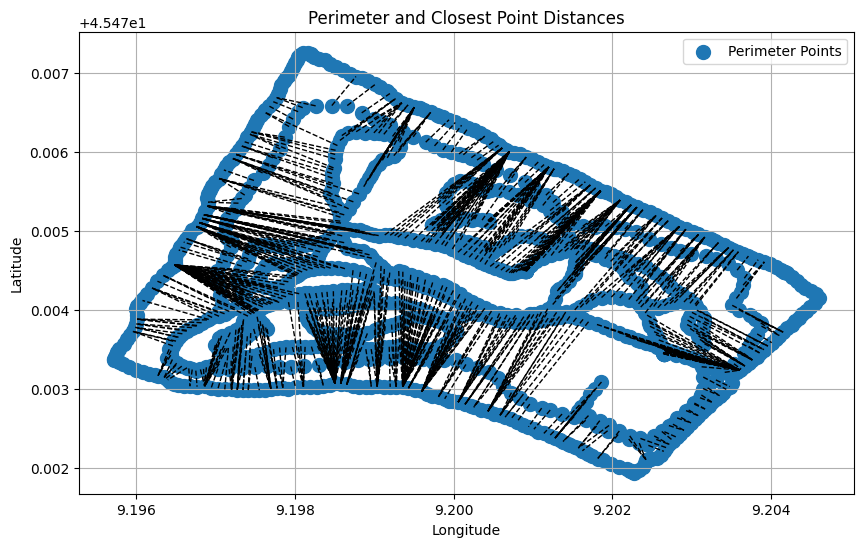

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['Longitude'], df['Latitude'], cmap='viridis', s=100, label='Perimeter Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Perimeter and Closest Point Distances')
plt.grid(True)

# Plot lines showing the distances to the closest perimeter points
for i, row in df_no_perimeter.iterrows():
    start_lat, start_lon = row['Latitude'], row['Longitude']
    closest_lat, closest_lon = row['Closest_Perimeter_Point']
    plt.plot([start_lon, closest_lon], [start_lat, closest_lat], 'k--', linewidth=1)

plt.legend()
plt.show()

<ipython-input-23-a84020feb9f2>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X, Y, cmap='viridis', s=100, label='Data Points')


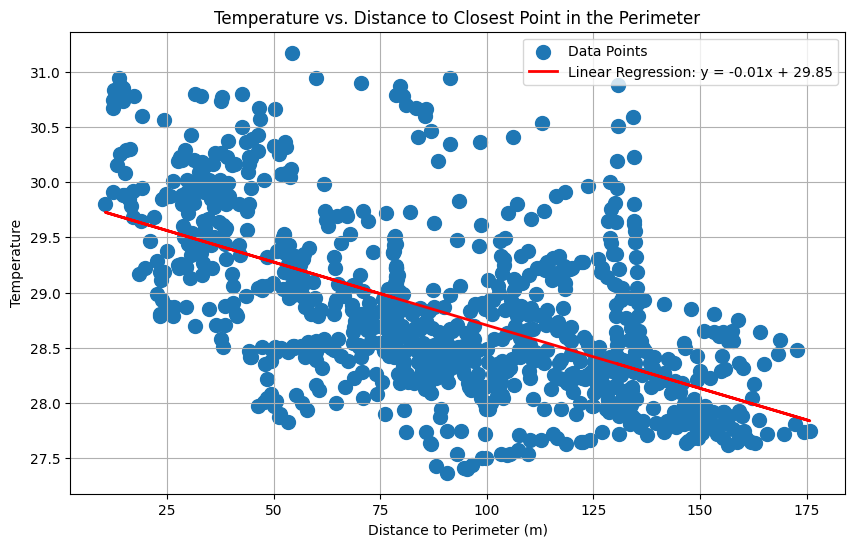

In [ ]:
# Extract X (distance) and Y (temperature) for linear regression
X = df_no_perimeter[['Distance_to_Perimeter']].values
Y = df_no_perimeter['Temperature'].values

# Perform linear regression
model = LinearRegression()
model.fit(X, Y)
intercept = model.intercept_
slope = model.coef_[0]

# Predict Y values using the model
predicted_Y = model.predict(X)

# Plotting temperature against distance to perimeter with linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, cmap='viridis', s=100, label='Data Points')
plt.plot(X, predicted_Y, color='red', linewidth=2, label=f'Linear Regression: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('Distance to Perimeter (m)')
plt.ylabel('Temperature')
plt.title('Temperature vs. Distance to Closest Point in the Perimeter')
plt.legend()
plt.grid(True)
plt.show()

## Geospatial Analysis

In [ ]:
# Center of the map (average of latitude and longitude)
map_center = [data['Latitude'].mean(), data['Longitude'].mean()]

# Create a map
mymap = folium.Map(location=map_center, zoom_start=15)

# Add points to the map
for idx, row in data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']],
                  popup=f"Temp: {row['Temperature']}, Humidity: {row['Humidity']}, Air Quality: {row['Air Quality']}").add_to(mymap)

mymap.save("./maps/map-unified.html")


In [ ]:
# Create a color map
colormap = cm.linear.YlOrRd_09.scale(df['Temperature'].min(), df['Temperature'].max())

# Create a map centered around the average latitude and longitude
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=15)

# Add temperature data as circle markers with color according to temperature
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        popup=f'Temperature: {row["Temperature"]} °C',
        color=colormap(row['Temperature']),
        fill=True,
        fill_color=colormap(row['Temperature']),
        fill_opacity=0.7
    ).add_to(m)

# Add colormap legend
colormap.caption = 'Temperature'
colormap.add_to(m)

# Save the map to an HTML file
m.save('./temperature-maps/temp-map-unified.html')

In [ ]:
# Create a color map
colormap = cm.linear.YlOrRd_09.scale(df['Temperature'].min(), df['Temperature'].max())

# Create a map centered around the average latitude and longitude
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=15, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr="<a href=https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}>Felipe</a>")

# Add temperature data as circle markers with color according to temperature
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        popup=f'Temperature: {row["Temperature"]} °C',
        color=colormap(row['Temperature']),
        fill=True,
        fill_color=colormap(row['Temperature']),
        fill_opacity=0.7
    ).add_to(m)

# Add colormap legend
colormap.caption = 'Temperature'
colormap.add_to(m)

# Save the map to an HTML file
m.save('./temperature-maps/temp-map-unified-sat.html')